# Introduction to Deep Learning, Assignment 2, Task 2

# Introduction


The goal of this assignment is to learn how to use encoder-decoder recurrent neural networks (RNNs). Specifically we will be dealing with a sequence to sequence problem and try to build recurrent models that can learn the principles behind simple arithmetic operations (**integer addition, subtraction and multiplication.**).

<img src="https://i.ibb.co/5Ky5pbk/Screenshot-2023-11-10-at-07-51-21.png" alt="Screenshot-2023-11-10-at-07-51-21" border="0" width="500"></a>

In this assignment you will be working with three different kinds of models, based on input/output data modalities:
1. **Text-to-text**: given a text query containing two integers and an operand between them (+ or -) the model's output should be a sequence of integers that match the actual arithmetic result of this operation
2. **Image-to-text**: same as above, except the query is specified as a sequence of images containing individual digits and an operand.
3. **Text-to-image**: the query is specified in text format as in the text-to-text model, however the model's output should be a sequence of images corresponding to the correct result.


### Description
Let us suppose that we want to develop a neural network that learns how to add or subtract
two integers that are at most two digits long. For example, given input strings of 5 characters: ‘81+24’ or
’41-89’ that consist of 2 two-digit long integers and an operand between them, the network should return a
sequence of 3 characters: ‘105 ’ or ’-48 ’ that represent the result of their respective queries. Additionally,
we want to build a model that generalizes well - if the network can extract the underlying principles behind
the ’+’ and ’-’ operands and associated operations, it should not need too many training examples to generate
valid answers to unseen queries. To represent such queries we need 13 unique characters: 10 for digits (0-9),
2 for the ’+’ and ’-’ operands and one for whitespaces ’ ’ used as padding.
The example above describes a text-to-text sequence mapping scenario. However, we can also use different
modalities of data to represent our queries or answers. For that purpose, the MNIST handwritten digit
dataset is going to be used again, however in a slightly different format. The functions below will be used to create our datasets.

---

*To work on this notebook you should create a copy of it.*

When using the Lab Computers, download the Jupyter Notebook to one of the machines first.

If you want to use Google Colab, you should first copy this notebook and enable GPU runtime in 'Runtime -> Change runtime type -> Hardware acceleration -> GPU **OR** TPU'.


# Function definitions for creating the datasets

First we need to create our datasets that are going to be used for training our models.

In order to create image queries of simple arithmetic operations such as '15+13' or '42-10' we need to create images of '+' and '-' signs using ***open-cv*** library. We will use these operand signs together with the MNIST dataset to represent the digits.

In [6]:
!pip install opencv-python


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [7]:
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import numpy as np
import tensorflow as tf
import random
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Dense, RNN, LSTM, Flatten, TimeDistributed, LSTMCell
from tensorflow.keras.layers import RepeatVector, Conv2D, SimpleRNN, GRU, Reshape, ConvLSTM2D, Conv2DTranspose

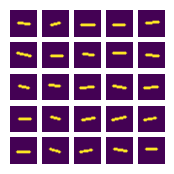

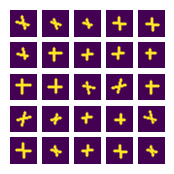

In [8]:
from scipy.ndimage import rotate


# Create plus/minus operand signs
def generate_images(number_of_images=50, sign='-'):
    blank_images = np.zeros([number_of_images, 28, 28])  # Dimensionality matches the size of MNIST images (28x28)
    x = np.random.randint(12, 16, (number_of_images, 2)) # Randomized x coordinates
    y1 = np.random.randint(6, 10, number_of_images)       # Randomized y coordinates
    y2 = np.random.randint(18, 22, number_of_images)     # -||-

    for i in range(number_of_images): # Generate n different images
        cv2.line(blank_images[i], (y1[i], x[i,0]), (y2[i], x[i, 1]), (255,0,0), 2, cv2.LINE_AA)     # Draw lines with randomized coordinates
        if sign == '+':
            cv2.line(blank_images[i], (x[i,0], y1[i]), (x[i, 1], y2[i]), (255,0,0), 2, cv2.LINE_AA) # Draw lines with randomized coordinates

    return blank_images

def show_generated(images, n=5):
    plt.figure(figsize=(2, 2))
    for i in range(n**2):
        plt.subplot(n, n, i+1)
        plt.axis('off')
        plt.imshow(images[i])
    plt.show()

show_generated(generate_images())
show_generated(generate_images(sign='+'))

In [9]:
def create_data(highest_integer, num_addends=2, operands=['+', '-']):
    """
    Creates the following data for all pairs of integers up to [1:highest integer][+/-][1:highest_integer]:

    @return:
    X_text: '51+21' -> text query of an arithmetic operation (5)
    X_img : Stack of MNIST images corresponding to the query (5 x 28 x 28) -> sequence of 5 images of size 28x28
    y_text: '72' -> answer of the arithmetic text query
    y_img :  Stack of MNIST images corresponding to the answer (3 x 28 x 28)

    Images for digits are picked randomly from the whole MNIST dataset.
    """

    num_indices = [np.where(MNIST_labels==x) for x in range(10)]
    num_data = [MNIST_data[inds] for inds in num_indices]
    image_mapping = dict(zip(unique_characters[:10], num_data))
    image_mapping['-'] = generate_images()
    image_mapping['+'] = generate_images(sign='+')
    image_mapping['*'] = generate_images(sign='*')
    image_mapping[' '] = np.zeros([1, 28, 28])

    X_text, X_img, y_text, y_img = [], [], [], []

    for i in range(highest_integer + 1):      # First addend
        for j in range(highest_integer + 1):  # Second addend
            for sign in operands: # Create all possible combinations of operands
                query_string = to_padded_chars(str(i) + sign + str(j), max_len=max_query_length, pad_right=True)
                query_image = []
                for n, char in enumerate(query_string):
                    image_set = image_mapping[char]
                    index = np.random.randint(0, len(image_set), 1)
                    query_image.append(image_set[index].squeeze())

                result = eval(query_string)
                result_string = to_padded_chars(result, max_len=max_answer_length, pad_right=True)
                result_image = []
                for n, char in enumerate(result_string):
                    image_set = image_mapping[char]
                    index = np.random.randint(0, len(image_set), 1)
                    result_image.append(image_set[index].squeeze())

                X_text.append(query_string)
                X_img.append(np.stack(query_image))
                y_text.append(result_string)
                y_img.append(np.stack(result_image))

    return np.stack(X_text), np.stack(X_img)/255., np.stack(y_text), np.stack(y_img)/255.

def to_padded_chars(integer, max_len=3, pad_right=False):
    """
    Returns a string of len()=max_len, containing the integer padded with ' ' on either right or left side
    """
    length = len(str(integer))
    padding = (max_len - length) * ' '
    if pad_right:
        return str(integer) + padding
    else:
        return padding + str(integer)


# Creating our data

The dataset consists of 20000 samples that (additions and subtractions between all 2-digit integers) and they have two kinds of inputs and label modalities:

  **X_text**: strings containing queries of length 5: ['  1+1  ', '11-18', ...]

  **X_image**: a stack of images representing a single query, dimensions: [5, 28, 28]

  **y_text**: strings containing answers of length 3: ['  2', '156']

  **y_image**: a stack of images that represents the answer to a query, dimensions: [3, 28, 28]

(20000,) (20000, 5, 28, 28) (20000,) (20000, 3, 28, 28)
Query #2871

X_text: "14-35" = y_text: "-21"


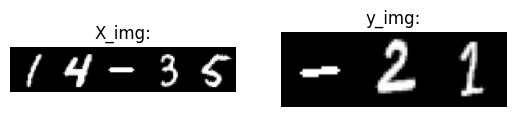

Query #179

X_text: "0-89 " = y_text: "-89"


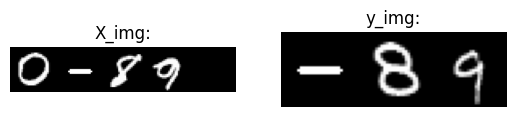

Query #4559

X_text: "22-79" = y_text: "-57"


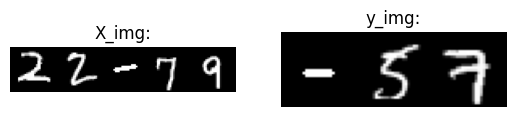

Query #8667

X_text: "43-33" = y_text: "10 "


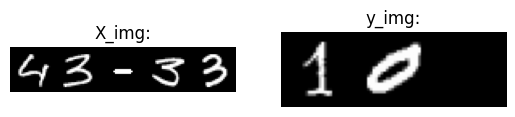

Query #6618

X_text: "33+9 " = y_text: "42 "


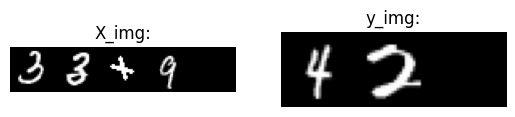

Query #6935

X_text: "34-67" = y_text: "-33"


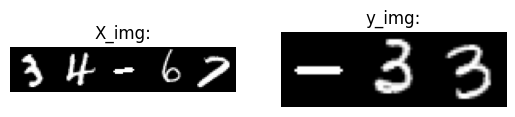

Query #8596

X_text: "42+98" = y_text: "140"


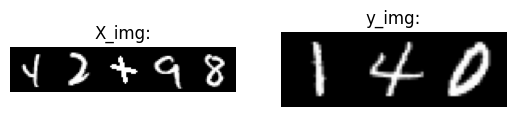

Query #5167

X_text: "25-83" = y_text: "-58"


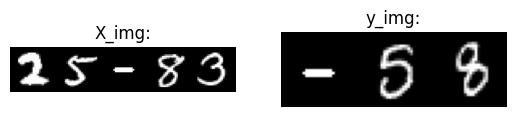

Query #5328

X_text: "26+64" = y_text: "90 "


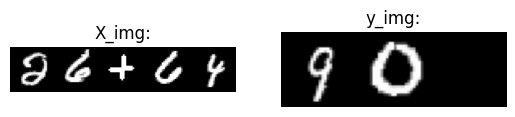

Query #2661

X_text: "13-30" = y_text: "-17"


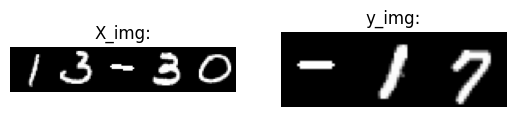

In [10]:
# Illustrate the generated query/answer pairs

unique_characters = '0123456789+- '       # All unique characters that are used in the queries (13 in total: digits 0-9, 2 operands [+, -], and a space character ' '.)
highest_integer = 99                      # Highest value of integers contained in the queries

max_int_length = len(str(highest_integer))# Maximum number of characters in an integer
max_query_length = max_int_length * 2 + 1 # Maximum length of the query string (consists of two integers and an operand [e.g. '22+10'])
max_answer_length = 3    # Maximum length of the answer string (the longest resulting query string is ' 1-99'='-98')

# Create the data (might take around a minute)
(MNIST_data, MNIST_labels), _ = tf.keras.datasets.mnist.load_data()
X_text, X_img, y_text, y_img = create_data(highest_integer)
print(X_text.shape, X_img.shape, y_text.shape, y_img.shape)


## Display the samples that were created
def display_sample(n):
    labels = ['X_img:', 'y_img:']
    for i, data in enumerate([X_img, y_img]):
        plt.subplot(1,2,i+1)
        # plt.set_figheight(15)
        plt.axis('off')
        plt.title(labels[i])
        plt.imshow(np.hstack(data[n]), cmap='gray')
    print('='*50, f'\nQuery #{n}\n\nX_text: "{X_text[n]}" = y_text: "{y_text[n]}"')
    plt.show()

for _ in range(10):
    display_sample(np.random.randint(0, 10000, 1)[0])

## Helper functions

The functions below will help with input/output of the data.

In [11]:
# One-hot encoding/decoding the text queries/answers so that they can be processed using RNNs
# You should use these functions to convert your strings and read out the output of your networks

def encode_labels(labels, max_len=3):
  n = len(labels)
  length = len(labels[0])
  char_map = dict(zip(unique_characters, range(len(unique_characters))))
  one_hot = np.zeros([n, length, len(unique_characters)])
  for i, label in enumerate(labels):
      m = np.zeros([length, len(unique_characters)])
      for j, char in enumerate(label):
          m[j, char_map[char]] = 1
      one_hot[i] = m

  return one_hot


def decode_labels(labels):
    pred = np.argmax(labels, axis=2)
    predicted = [''.join([unique_characters[i] for i in j]) for j in pred]

    return predicted

X_text_onehot = encode_labels(X_text)
y_text_onehot = encode_labels(y_text)

print(X_text_onehot.shape, y_text_onehot.shape)

(20000, 5, 13) (20000, 3, 13)


---
---

## I. Text-to-text RNN model

The following code showcases how Recurrent Neural Networks (RNNs) are built using Keras. Several new layers are going to be used:

1. LSTM
2. TimeDistributed
3. RepeatVector

The code cell below explains each of these new components.

<img src="https://i.ibb.co/NY7FFTc/Screenshot-2023-11-10-at-09-27-25.png" alt="Screenshot-2023-11-10-at-09-27-25" border="0" width="500"></a>


In [12]:
def build_text2text_model():

    # We start by initializing a sequential model
    text2text = tf.keras.Sequential()

    # "Encode" the input sequence using an RNN, producing an output of size 256.
    # In this case the size of our input vectors is [5, 13] as we have queries of length 5 and 13 unique characters. Each of these 5 elements in the query will be fed to the network one by one,
    # as shown in the image above (except with 5 elements).
    # Hint: In other applications, where your input sequences have a variable length (e.g. sentences), you would use input_shape=(None, unique_characters).
    text2text.add(LSTM(256, input_shape=(None, len(unique_characters))))

    # As the decoder RNN's input, repeatedly provide with the last output of RNN for each time step. Repeat 3 times as that's the maximum length of the output (e.g. '  1-99' = '-98')
    # when using 2-digit integers in queries. In other words, the RNN will always produce 3 characters as its output.
    text2text.add(RepeatVector(max_answer_length))

    # By setting return_sequences to True, return not only the last output but all the outputs so far in the form of (num_samples, timesteps, output_dim). This is necessary as TimeDistributed in the below expects
    # the first dimension to be the timesteps.
    text2text.add(LSTM(256, return_sequences=True))

    # Apply a dense layer to the every temporal slice of an input. For each of step of the output sequence, decide which character should be chosen.
    text2text.add(TimeDistributed(Dense(len(unique_characters), activation='softmax')))

    # Next we compile the model using categorical crossentropy as our loss function.
    text2text.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    #text2text.summary()

    return text2text

In [ ]:
## Your code (look at the assignment description for your tasks for text-to-text model):
## Your first task is to fit the text2text model using X_text and y_text)
tf.keras.utils.set_random_seed(67)
#percentage of X to y:
scores={}
for percentage in [5, 10, 15, 25, 50, 75, 90, 99]:
  print(f"Training with {percentage}% of data")

  X_train, X_test, y_train, y_test = train_test_split(X_text_onehot, y_text_onehot, train_size=percentage/100, random_state=67)

  text2text = build_text2text_model()
  text2text.fit(X_train, y_train, epochs=15, verbose=0)
  results = text2text.evaluate(X_test, y_test, verbose=0)
  print("Test loss, Test accuracy:", results)



  # Split test set into add and subtraction groups
  add_indices = []
  sub_indices = []
  for i in range(min(1000,len(X_test))):
      q_str = decode_labels(X_test[i:i+1])[0]
      if "+" in q_str:
          add_indices.append(i)
      if "-" in q_str:
          sub_indices.append(i)

  # Balance sample count
  n_samples = min(len(add_indices), len(sub_indices), 100)  
  add_indices = np.random.choice(add_indices, n_samples, replace=False)
  sub_indices = np.random.choice(sub_indices, n_samples, replace=False)

  # Accuracy calculations
  add_correct = 0
  sub_correct = 0

  for idx in add_indices:
      pred = text2text.predict(X_test[idx:idx+1], verbose=0)
      if decode_labels(pred)[0] == decode_labels(y_test[idx:idx+1])[0]:
          add_correct += 1

  for idx in sub_indices:
      pred = text2text.predict(X_test[idx:idx+1], verbose=0)
      if decode_labels(pred)[0] == decode_labels(y_test[idx:idx+1])[0]:
          sub_correct += 1

  add_acc = add_correct / n_samples
  sub_acc = sub_correct / n_samples

  print(f"Addition accuracy:{add_acc:.3f}")
  print(f"Subtraction accuracy:{sub_acc:.3f}")

  scores[percentage] = {
      "overall_loss": results[0],
      "overall_acc": results[1],
      "add_acc": add_acc,
      "sub_acc": sub_acc,
    }
  # Draw 10 random queries to display
  for _ in range(15):
      query_n = np.random.randint(0, len(X_test))
      query = X_test[query_n:query_n+1]

      prediction = text2text.predict(query, verbose=0)

      print("----------------------------------------")
      print(f"Quesion: {decode_labels(query)}")
      print(f"Pred: {decode_labels(prediction)}")
      print(f"Actual: {decode_labels(y_test[query_n:query_n+1])}")
 #scores.update({percentage: results})



Training with 5% of data


/home/ivanb/tf-venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt

percentages = list(scores.keys())
overall_acc = [scores[p]["overall_acc"] for p in percentages]
add_acc = [scores[p]["add_acc"] for p in percentages]
sub_acc = [scores[p]["sub_acc"] for p in percentages]
overall_loss = [scores[p]["overall_loss"] for p in percentages]

#accuracy plot
plt.figure(figsize=(10,5))
plt.plot(percentages, overall_acc, marker='o', linewidth=2, label='Overall Accuracy')
plt.plot(percentages, add_acc, marker='o', linewidth=2, label='Addition Accuracy')
plt.plot(percentages, sub_acc, marker='o', linewidth=2, label='Subtraction Accuracy')

plt.title("Accuracy vs Training Set Size")
plt.xlabel("Training Data Percentage (%)")
plt.ylabel("Accuracy")
plt.ylim(0,1.05)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()

# loss plot
plt.figure(figsize=(10,5))
plt.plot(percentages, overall_loss, marker='o', linewidth=2, label='Overall Loss', color='red')

plt.title("Loss vs Training Set Size")
plt.xlabel("Training Data Percentage (%)")
plt.ylabel("Loss")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()


In [ ]:
!pip install seaborn 

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
model_test=build_text2text_model()
X_train, X_test, y_train, y_test = train_test_split(X_text_onehot, y_text_onehot, train_size=0.90, random_state=67)

model_test.fit(X_train, y_train, epochs=30, verbose=0)

y_pred_probs = text2text.predict(X_test, verbose=0)
print(y_pred_probs.shape)
print(y_pred_probs[1])

y_pred = np.argmax(y_pred_probs, axis=-1)   
y_true = np.argmax(y_test, axis=-1)   
print(y_pred[1], y_true[1])      


#global confusion matrix
y_true_flat = y_true.reshape(-1)
y_pred_flat = y_pred.reshape(-1)
print(y_true_flat.shape, y_pred_flat.shape)
cm =  confusion_matrix(y_true_flat, y_pred_flat)
cm_norm = cm / cm.sum(axis=1, keepdims=True)

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=False,
    cmap="Blues",
    xticklabels=unique_characters,
    yticklabels=unique_characters
)
plt.title("Confusion Matrix (All Positions) - Raw Counts")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# normalized confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm_norm,
    annot=True,
    fmt=".2f",
    cmap="Blues",
    xticklabels=unique_characters,
    yticklabels=unique_characters
)
plt.title("Confusion Matrix (All Positions) - Normalized")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


#per-position confusion matrices

for pos in range(3):
    cm_pos = confusion_matrix(y_true[:, pos], y_pred[:, pos])
    cm_pos_norm = cm_pos / cm_pos.sum(axis=1, keepdims=True)

    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm_pos_norm,
        annot=True,
        fmt=".2f",
        cmap="Greens",
        xticklabels=unique_characters,
        yticklabels=unique_characters
    )
    plt.title(f"Confusion Matrix - Normalized (Position {pos})")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()


---
---

## II. Image to text RNN Model

Hint: There are two ways of building the encoder for such a model - again by using the regular LSTM cells (with flattened images as input vectors) or recurrect convolutional layers [ConvLSTM2D](https://keras.io/api/layers/recurrent_layers/conv_lstm2d/).

The goal here is to use **X_img** as inputs and **y_text** as outputs.

In [ ]:

from tensorflow.keras.layers import (
    Dense, RepeatVector, LSTM, TimeDistributed
)



In [40]:
def build_img2text_model():

    model = tf.keras.Sequential()

   #Convlotuional layers
    model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2D(filters=16,kernel_size=3,padding="same",activation="relu"),input_shape=(5, 28, 28, 1) ))
    model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPooling2D(pool_size=(2, 2))))  # 28 to 14

    model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2D(filters=32,kernel_size=3,padding="same",activation="relu")))
    model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPooling2D(pool_size=(2, 2))))  # 14 → 7


    #ConvLSTM 
    model.add(tf.keras.layers.ConvLSTM2D(
        filters=32,
        kernel_size=3,
        padding="same",
        return_sequences=True,
        dropout=0.2,
        recurrent_dropout=0.2
    ))

    model.add(tf.keras.layers.ConvLSTM2D(
        filters=16,                  
        kernel_size=3,
        padding="same",
        return_sequences=False,
        dropout=0.2,
        recurrent_dropout=0.2
    ))


    model.add(tf.keras.layers.GlobalAveragePooling2D())

    model.add(tf.keras.layers.Dense(128,activation="relu",kernel_regularizer=tf.keras.regularizers.l2(1e-4)))
    model.add(tf.keras.layers.Dropout(0.3))


    # Decoder

    model.add(tf.keras.layers.RepeatVector(max_answer_length))

    model.add(tf.keras.layers.LSTM(
        128,
        return_sequences=True,
        dropout=0.2
    ))

    model.add(tf.keras.layers.TimeDistributed(
        tf.keras.layers.Dense(
            len(unique_characters),
            activation="softmax"
        )
    ))

    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-3),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )

    model.summary()
    return model


In [41]:
model_img_to_text = build_img2text_model()

train_img_X, test_img_X, train_text_y, test_text_y = train_test_split(
    X_img, y_text_onehot, train_size=0.8, random_state=67
)
print(X_img.shape)
print(y_text_onehot.shape)
history_model_img_to_text = model_img_to_text.fit(
    train_img_X,
    train_text_y,
    epochs=200,
    batch_size=32,
    validation_split=0.1
)


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_36             │ (None, 5, 28, 28, 16)  │           160 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_37             │ (None, 5, 14, 14, 16)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_38             │ (None, 5, 14, 14, 32)  │         4,640 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_39             │ (None, 5, 7, 7, 32)    │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_11 (ConvLSTM2D)     │ (None, 5, 7, 7, 32)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_12 (ConvLSTM2D)     │ (None, 7, 7, 16)       │        27,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ (None, 16)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 128)            │         2,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_11 (RepeatVector) │ (None, 3, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_15 (LSTM)                  │ (None, 3, 128)         │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_40             │ (None, 3, 13)          │         1,677 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 241,805 (944.55 KB)

 Trainable params: 241,805 (944.55 KB)

 Non-trainable params: 0 (0.00 B)

(20000, 5, 28, 28)
(20000, 3, 13)
Epoch 1/200


E0000 00:00:1765069198.395538  217277 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: MutableGraphView::SortTopologically error: detected edge(s) creating cycle(s) {'StatefulPartitionedCall/sequential_11_1/conv_lstm2d_11_1/while/body/_67/sequential_11_1/conv_lstm2d_11_1/while/conv_lstm_cell_1/convolution_6' -> 'StatefulPartitionedCall/sequential_11_1/conv_lstm2d_11_1/while/body/_67/sequential_11_1/conv_lstm2d_11_1/while/conv_lstm_cell_1/ArithmeticOptimizer/AddOpsRewrite_Leaf_1_add_6', 'StatefulPartitionedCall/sequential_11_1/conv_lstm2d_11_1/while/body/_67/sequential_11_1/conv_lstm2d_11_1/while/conv_lstm_cell_1/mul_8' -> 'StatefulPartitionedCall/sequential_11_1/conv_lstm2d_11_1/while/body/_67/sequential_11_1/conv_lstm2d_11_1/while/conv_lstm_cell_1/add_7', 'StatefulPartitionedCall/sequential_11_1/conv_lstm2d_11_1/while/body/_67/sequential_11_1/conv_lstm2d_11_1/while/conv_lstm_cell_1/Sigmoid' -> 'StatefulPartitionedCall/sequential_11_1/conv_lstm2d_11_1/while/body/_67/sequential_1

450/450 ━━━━━━━━━━━━━━━━━━━━ 23s 43ms/step - accuracy: 0.3167 - loss: 2.0870 - val_accuracy: 0.3323 - val_loss: 2.0387
Epoch 2/200
450/450 ━━━━━━━━━━━━━━━━━━━━ 19s 41ms/step - accuracy: 0.3492 - loss: 2.0107 - val_accuracy: 0.3856 - val_loss: 1.9413
Epoch 3/200
450/450 ━━━━━━━━━━━━━━━━━━━━ 18s 40ms/step - accuracy: 0.3944 - loss: 1.8630 - val_accuracy: 0.3967 - val_loss: 1.7804
Epoch 4/200
450/450 ━━━━━━━━━━━━━━━━━━━━ 19s 42ms/step - accuracy: 0.4005 - loss: 1.7512 - val_accuracy: 0.4046 - val_loss: 1.6827
Epoch 5/200
450/450 ━━━━━━━━━━━━━━━━━━━━ 19s 41ms/step - accuracy: 0.4143 - loss: 1.6718 - val_accuracy: 0.4131 - val_loss: 1.6606
Epoch 6/200
450/450 ━━━━━━━━━━━━━━━━━━━━ 19s 42ms/step - accuracy: 0.4254 - loss: 1.6229 - val_accuracy: 0.4281 - val_loss: 1.6086
Epoch 7/200
450/450 ━━━━━━━━━━━━━━━━━━━━ 19s 42ms/step - accuracy: 0.4319 - loss: 1.5930 - val_accuracy: 0.4446 - val_loss: 1.5573
Epoch 8/200
450/450 ━━━━━━━━━━━━━━━━━━━━ 19s 41ms/step - accuracy: 0.4412 - loss: 1.5578 - val_

KeyboardInterrupt: 

In [ ]:
import numpy as np

num_samples = 30
loss, acc = model_img_to_text.evaluate(test_img_X, test_text_y, verbose=0)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {acc:.4f}")
preds = model_img_to_text.predict(test_img_X, verbose=0)

for i in range(num_samples):
    pred_idxs = np.argmax(preds[i], axis=-1)
    true_idxs = np.argmax(test_text_y[i], axis=-1)

    pred_text = ''.join(unique_characters[j] for j in pred_idxs)
    true_text = ''.join(unique_characters[j] for j in true_idxs)

    print(f"Sample {i}")
    print(f"  True: {true_text}")
    print(f"  Pred: {pred_text}")
    print('----------------------------------------')

Test Loss: 1.3078
Test Accuracy: 0.5243
Sample 0
  True: -7 
  Pred: -1 
------------------------------
Sample 1
  True: -26
  Pred: -24
------------------------------
Sample 2
  True: -23
  Pred: -22
------------------------------
Sample 3
  True: 142
  Pred: 144
------------------------------
Sample 4
  True: 50 
  Pred: 57 
------------------------------
Sample 5
  True: -18
  Pred: -12
------------------------------
Sample 6
  True: 9  
  Pred: 1  
------------------------------
Sample 7
  True: 86 
  Pred: 94 
------------------------------
Sample 8
  True: 85 
  Pred: 80 
------------------------------
Sample 9
  True: 54 
  Pred: 87 
------------------------------
Sample 10
  True: 81 
  Pred: 74 
------------------------------
Sample 11
  True: -50
  Pred: -54
------------------------------
Sample 12
  True: -55
  Pred: -64
------------------------------
Sample 13
  True: -52
  Pred: -54
------------------------------
Sample 14
  True: 127
  Pred: 129
--------------------------

---
---

## III. Text to image RNN Model

Hint: to make this model work really well you could use deconvolutional layers in your decoder (you might need to look up ***Conv2DTranspose*** layer). However, regular vector-based decoder will work as well.

The goal here is to use **X_text** as inputs and **y_img** as outputs.

In [ ]:
def build_text2img_model():


    model = tf.keras.Sequential()

    #ENCODER 
    #model.add(LSTM(256, input_shape=(max_query_length, len(unique_characters)), return_sequences=True))
  #  model.add(LSTM(256, input_shape=(max_query_length, len(unique_characters)), return_sequences=True))
    model.add(LSTM(256, input_shape=(max_query_length, len(unique_characters))))
    model.add(RepeatVector(3))   
   
   
   
    #Decoder    
    model.add(LSTM(256, return_sequences=True))  
 
    
    # Turn each 256 vector into a 7×7×64 shape for deconvolution
    model.add(TimeDistributed(Dense(7*7*64, activation='relu')))
    model.add(TimeDistributed(Reshape((7, 7, 64)))) 
    # Upsample 7 to 14 - reduce channels
    model.add(TimeDistributed(
        Conv2DTranspose(32, (3, 3), strides=2, padding='same', activation='relu')
    ))  
    # Upsample 14 to 28
    model.add(TimeDistributed(
        Conv2DTranspose(16, (3, 3), strides=2, padding='same', activation='relu')
    ))
    #final 1channel image
    model.add(TimeDistributed(
        Conv2DTranspose(1, (3, 3), padding='same', activation='sigmoid')
    )) 

    model.compile(optimizer='adam', loss='binary_crossentropy')
    return model


In [79]:
X_train_text, X_test_text, y_train_img, y_test_img = train_test_split(
    X_text_onehot,      
    y_img,              
    train_size=0.7,
    random_state=67,
    shuffle=True
)


In [ ]:
model = build_text2img_model()

history = model.fit(
    X_train_text,        
    y_train_img,        
    epochs=20,
    batch_size=8,
    validation_data=(X_test_text, y_test_img)
)


Epoch 1/20
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 23s 12ms/step - loss: 0.2193 - val_loss: 0.1929
Epoch 2/20
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 19s 11ms/step - loss: 0.1888 - val_loss: 0.1852
Epoch 3/20
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 19s 11ms/step - loss: 0.1845 - val_loss: 0.1844
Epoch 4/20
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 19s 11ms/step - loss: 0.1821 - val_loss: 0.1817
Epoch 5/20
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 18s 10ms/step - loss: 0.1811 - val_loss: 0.1819
Epoch 6/20
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - loss: 0.1797 - val_loss: 0.1787
Epoch 7/20
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 18s 10ms/step - loss: 0.1788 - val_loss: 0.1767
Epoch 8/20
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 19s 11ms/step - loss: 0.1776 - val_loss: 0.1767
Epoch 9/20
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - loss: 0.1769 - val_loss: 0.1772
Epoch 10/20
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 18s 10ms/step - loss: 0.1760 - val_loss: 0.1753
Epoch 11/20
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - loss: 0.1755 - val_loss: 0.1742
Epoch 12

10-5 


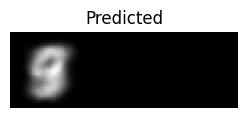

60-30


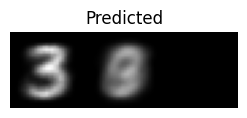

74-10


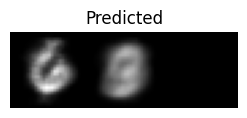

63-7 


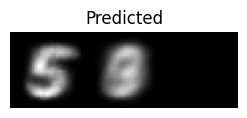

48+76


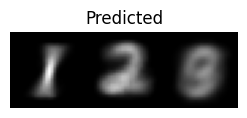

28-9 


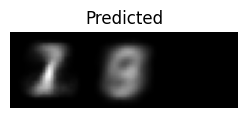

1-25 


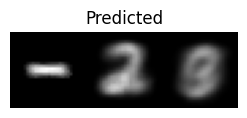

72+25


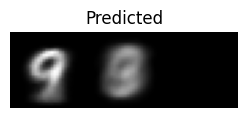

22-4 


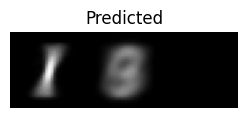

75+92


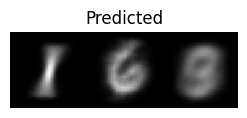

84+98


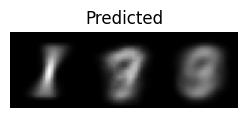

70+14


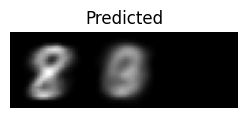

43+79


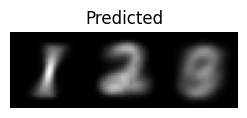

57+21


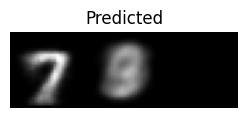

96+67


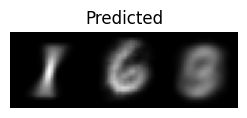

11+39


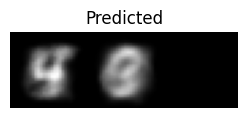

41+1 


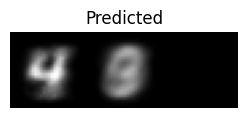

36-30


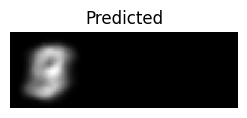

22+60


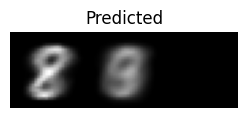

72-46


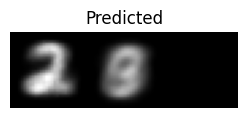

99+72


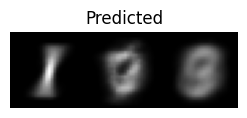

7-74 


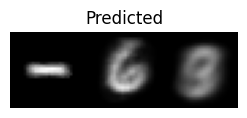

41+85


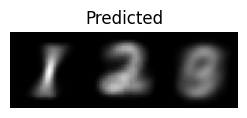

51-31


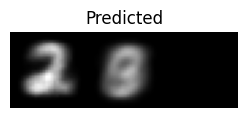

68-75


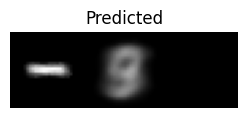

91+96


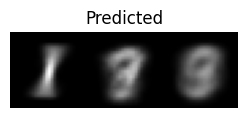

90+93


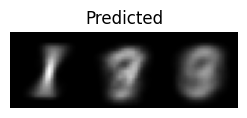

80+13


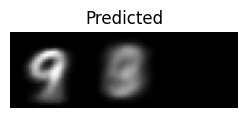

84-90


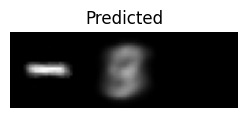

62+53


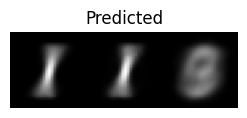

In [ ]:
for i in range(30):
    
    idx = random.randint(0, len(X_test_text) - 1)
    x = X_test_text[idx:idx+1]
    y_pred = model.predict(x, verbose=0)[0]
    y_true = y_test_img[idx]
    query_str = decode_labels(x)[0]

    # Plot
    plt.figure(figsize=(10, 3))
    print(query_str)
    plt.subplot(1, 3, 2)
    plt.title("Predicted")
    plt.imshow(np.hstack([y_pred[j, :, :, 0] for j in range(3)]), cmap="gray")
    plt.axis("off")

 
    plt.show()